In [34]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [35]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
dataset_path = '/kaggle/input/animals10/raw-img'
full_data = datasets.ImageFolder(dataset_path, transform=transform)
print("Total number of images:", len(full_data))

Total number of images: 26179


In [38]:
train_size = int(0.8 * len(full_data))
validation_size = len(full_data) - train_size
train_data, validation_data = random_split(full_data, [train_size, validation_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

In [39]:
model = models.googlenet(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%, Validation Loss: {validation_loss/len(validation_loader)}')


Epoch 1/10, Loss: 0.5111541391783998
Accuracy: 87.56684491978609%, Validation Loss: 0.3732486064886538
Epoch 2/10, Loss: 0.32011710655029496
Accuracy: 89.34300993124522%, Validation Loss: 0.3345541074508574
Epoch 3/10, Loss: 0.24979210548273478
Accuracy: 89.85867074102369%, Validation Loss: 0.3312844445520058
Epoch 4/10, Loss: 0.21239879541952192
Accuracy: 87.45225362872422%, Validation Loss: 0.4327340601693566
Epoch 5/10, Loss: 0.17286044751713409
Accuracy: 89.70588235294117%, Validation Loss: 0.34655022011252073
Epoch 6/10, Loss: 0.14788538782807592
Accuracy: 89.3048128342246%, Validation Loss: 0.35456321670151336
Epoch 7/10, Loss: 0.1409410790071062
Accuracy: 90.10695187165776%, Validation Loss: 0.356740786171541
Epoch 8/10, Loss: 0.12189175944885537
Accuracy: 90.6035141329259%, Validation Loss: 0.3300289958601863
Epoch 9/10, Loss: 0.1111884115174953
Accuracy: 92.13139801375095%, Validation Loss: 0.29671898198302654
Epoch 10/10, Loss: 0.09375429306221941
Accuracy: 89.55309396485868%

In [43]:
predicted_labels = []
actual_labels = []

model.eval()

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)

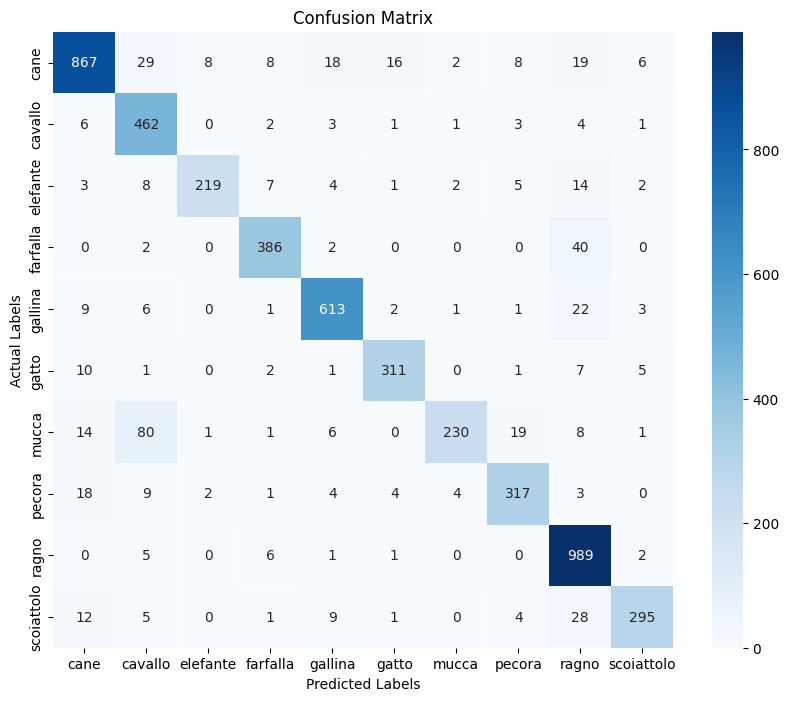

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [46]:
from sklearn.metrics import classification_report

report = classification_report(actual_labels, predicted_labels, target_names=label_encoder.classes_)

print(report)

              precision    recall  f1-score   support

        cane       0.92      0.88      0.90       981
     cavallo       0.76      0.96      0.85       483
    elefante       0.95      0.83      0.88       265
    farfalla       0.93      0.90      0.91       430
     gallina       0.93      0.93      0.93       658
       gatto       0.92      0.92      0.92       338
       mucca       0.96      0.64      0.77       360
      pecora       0.89      0.88      0.88       362
       ragno       0.87      0.99      0.93      1004
  scoiattolo       0.94      0.83      0.88       355

    accuracy                           0.90      5236
   macro avg       0.91      0.87      0.89      5236
weighted avg       0.90      0.90      0.89      5236

